In [52]:
from salad.serialize import read
import astropy.table
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from salad.regression import RegressionResult

In [79]:
detector = 1
snr = 5.0
catalog = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/catalog.pkl")
images = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/images.pkl")
fakes = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/fakes.pkl")
clusters = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/clusters.pkl")
projection = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/projection.pkl")
refined1 = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/refined_clusters_1.pkl")
refined2 = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/refined_clusters_2.pkl")
refined_filtered = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/refined_clusters_2_filtered.pkl")
hough = read(f"../search/new_pipeline/DEEP/20190403/A0c/detector_{detector}/snr_{snr}/unshuffled/hough.pkl")

In [184]:
projection.reference_time

AttributeError: 'numpy.float64' object has no attribute 'value'

In [85]:
def recover(fakes, clusters, catalog, match_threshold=1/3600, projection=None, hough=None):
    c_fake = SkyCoord(fakes['RA']*u.deg, fakes['DEC']*u.deg)
    t_fake = fakes['mjd_mid'].data[:, None]
        
    t1 = astropy.table.Table(data=[c_fake.ra, c_fake.dec, fakes['ORBITID'], fakes['EXPNUM']], names=['ra', 'dec', 'orbit', 'expnum'])

    t_points = []
    t_line = []
    for i, cluster in enumerate(clusters):
        # recover points
        e = cluster.points[:, -1].astype(int)
        c_cluster = SkyCoord(cluster.points[:, 0] * u.deg, cluster.points[:, 1] * u.deg)
        t2 = astropy.table.Table(
            data=[[i]*len(e), c_cluster.ra, c_cluster.dec, e], names=['cluster', 'ra', 'dec', 'expnum']
        )
        t_points.append(t2)
        
        # recover line
        if 'line' in cluster.extra:
            line = cluster.extra['line']
        elif 'b' in cluster.extra:
            alpha = np.array(
                [
                    (cluster.extra['x'] * hough.dx + hough.min_x), 
                    (cluster.extra['y'] * hough.dy + hough.min_y)
                ]
            ) * u.deg
            beta = projection.directions.b[cluster.extra['b']][None, :]
            line = RegressionResult()
            line.beta = beta
            line.alpha = alpha
            t_fake = (fakes['mjd_mid'].data[:, None] - projection.reference_time)
        
        line_locations = t_fake @ line.beta * u.day + line.alpha
        e = fakes['EXPNUM']
        o = fakes['ORBITID']
        c_line = SkyCoord(line_locations[:, 0], line_locations[:, 1])
        t2 = astropy.table.Table(
            data=[[i]*len(e), c_line.ra, c_line.dec, e, o], 
            names=['cluster', 'ra', 'dec', 'expnum', 'orbit']
        )
        t_line.append(t2)        

    t_points = astropy.table.vstack(t_points)
    t_line = astropy.table.vstack(t_line)

    
    # this matches cluster points to fake detections
    matches = {orbit : {"points": {}, "line": {}, "catalog": 0, "info": {}} for orbit in set(fakes['ORBITID'])}
    
    for g in astropy.table.join(t1, t_points, keys=['expnum']).group_by(["orbit", "cluster"]).groups:
        sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
        n_matches = (sep.value < 1/3600).sum()
        o = int(g[0]['orbit'])
        c = int(g[0]['cluster'])
        if n_matches > 0:
            matches[o]['points'][c] = n_matches + matches[o]['points'].get(c, 0)

    # this matches cluster lines to fake detections
#     matches_line = {orbit : {} for orbit in set(fakes['ORBITID'])}
    for g in astropy.table.join(t1, t_line, keys=['expnum', 'orbit']).group_by(["orbit", "cluster"]).groups:
        sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
        n_matches = (sep.value < 1/3600).sum()
        o = int(g[0]['orbit'])
        c = int(g[0]['cluster'])
        if n_matches > 0:
            matches[o]['line'][c] = n_matches + matches[o]['line'].get(c, 0)
    
    # this matches catalog points to fake detections
    x = catalog.X(columns=['ra', 'dec', 'time', 'exposures'])
    c_catalog = SkyCoord(x[:, 0]*u.deg, x[:, 1]*u.deg)
    t_catalog = astropy.table.Table(
        data=[c_catalog.ra, c_catalog.dec, x[:, 3]], 
        names=['ra', 'dec', 'expnum']
    )
    for g in astropy.table.join(t1, t_catalog, keys=['expnum']).group_by(["orbit"]).groups:
        sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
        n_matches = (sep.value < 1/3600).sum()
        o = int(g[0]['orbit'])
        matches[o]['catalog'] = n_matches

    for g in fakes.group_by("ORBITID").groups:
        idx = np.argsort(g['mjd_mid'])
        dt = (g[idx]['mjd_mid'][-1] - g[idx]['mjd_mid'][0]) * u.day

        if dt == 0:
            vra = np.nan
            vdec = np.nan
        else:
            dra = (g[idx]['RA'][-1] - g[idx]['RA'][0]) * u.deg
            ddec = (g[idx]['DEC'][-1] - g[idx]['DEC'][0]) * u.deg
            vra = dra / dt
            vdec = ddec / dt

        o = int(g[0]['ORBITID'])
        matches[o]['info'] = dict(
            vra=vra,
            vdec=vdec,
        )

        if projection is not None:
            dv = projection.directions.b - np.array([vra.value, vdec.value]) * u.deg/u.day
            min_dv = ((dv**2).sum(axis=1)**0.5).min()
            distance = min_dv * dt
            matches[o]['info']['min_dv'] = min_dv
            matches[o]['info']['distance'] = distance
        if hough is not None:
            matches[o]['info']['findable'] = (distance < hough.dx * u.deg)
        
    return matches

In [ ]:
# What I want to know is:
# Number of results
# Number of fakes recovered
# - clusters
# - refine
# - refine
# - filter_n
# - filter_v

# A successful recovery means:
# Points: at least 50% of points in a cluster belong to the fake
# Line: at least 50% of the points in the catalog are within dx=1 arcsec of the line

# Points: 
# - what is the fraction of the fake catalog points that are within this cluster
# Line: what is the fraction of the catalog points for the fake that lie within 1 arcsec of the line

# For each fake: 
# - Did I find it?
# - How often did I find it?
# fake + cluster/line -> found

# I have a few cases:
# - fraction of fakes gathered
# - fraction of fakes 
# I could have gathered all of the points, but I can't distinguish it from other sources (50%)
# I could have gathered 

In [87]:
import matplotlib.pyplot as plt

In [116]:
steps = [clusters, refined1, refined2, refined_filtered]
recoveries = [
    recover(fakes, c, catalog, hough=hough, projection=projection)
    for c in steps
]

In [113]:
recoveries[1][14621325]

{'points': {6: 85},
 'line': {6: 104},
 'catalog': 85,
 'info': {'vra': <Quantity -0.14885475 deg / d>,
  'vdec': <Quantity 0.15269422 deg / d>,
  'min_dv': <Quantity 0.00714488 deg / d>,
  'distance': <Quantity 0.0012745 deg>,
  'findable': True}}

In [151]:
i = 0
p = []
r = []
for k in recoveries[i]:
    for c in recoveries[i][k]['points']:
        precision = recoveries[i][k]['points'][c] / len(steps[i].clusters[c].points)
        recall = recoveries[i][k]['points'][c] / recoveries[i][k]['catalog']
        p.append(precision)
        r.append(recall)
        
p, r

([0.9139784946236559, 0.8679245283018868, 0.21875, 0.03225806451612903],
 [1.0, 0.9787234042553191, 0.14893617021276595, 0.14285714285714285])

In [ ]:
# what I want to know is
# for each fake:


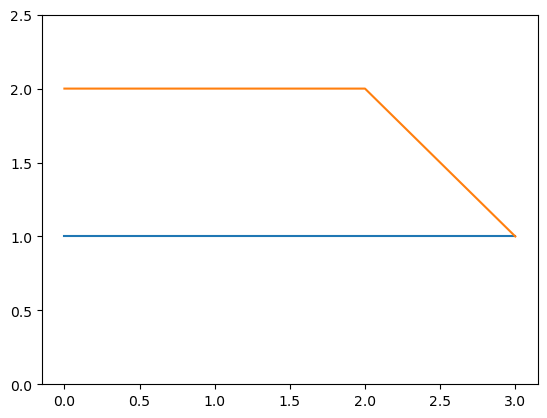

In [161]:
orbits = list(set(fakes['ORBITID']))

for orbit in orbits:
    x = []
    y = []
    for i in range(len(steps)):
        r = recoveries[i]
        s = steps[i]
        if orbit in r:
            num_clusters = len(recoveries[i][orbit]['points'])
            if num_clusters > 0:

                precision = recoveries[i][k]['points'][c] / len(steps[i].clusters[c].points)
                recall = recoveries[i][k]['points'][c] / recoveries[i][k]['catalog']                
                x.append(i)
                y.append(num_clusters)
    if x:
        plt.plot(x, y)

plt.ylim(0, 2.5)
plt.show()

In [144]:
# number of clusters with fakes
recoveries[1][14621325]

{'points': {6: 85},
 'line': {6: 104},
 'catalog': 85,
 'info': {'vra': <Quantity -0.14885475 deg / d>,
  'vdec': <Quantity 0.15269422 deg / d>,
  'min_dv': <Quantity 0.00714488 deg / d>,
  'distance': <Quantity 0.0012745 deg>,
  'findable': True}}

In [114]:
# precision = number of fakes in cluster / number of points in cluster
# recall = number of fakes in cluster / number of fakes in catalog
precision = recoveries[1][14621325]['points'][6] / len(refined1.clusters[6].points)
recall = min(recoveries[1][14621325]['points'][6] / recoveries[1][14621325]['catalog'], 1)
precision, recall

(0.8173076923076923, 1.0)

In [115]:
# line:
# precision = number of fakes near line / number of fakes in jected
# recall = number of fake near line / number of fakes injected
precision = recoveries[1][14621325]['line'][6] / len(images.images)
recall = min(recoveries[1][14621325]['line'][6] / recoveries[1][14621325]['catalog'], 1)
precision, recall

(1.0, 1)

In [164]:
r[orbit]['points']

{}

In [182]:
num_fakes = len(orbits)
fraction_found = [] # fraction found
purity = []
for i in range(len(steps)):
    r = recoveries[i]
    s = steps[i]
    found = 0
    possible = 0
    ps = []
    for orbit in orbits:
        # found at this step?
        if orbit in r:
            found_in = 0
            was_in = len(r[orbit]['points'])
            p = []
            for c in r[orbit]['points']:
                precision = r[orbit]['points'][c] / len(s.clusters[c].points)
                recall = r[orbit]['points'][c] / r[orbit]['catalog']
                if precision > 0.5:
                    found_in += 1
                p.append(precision)
            if found_in > 0:
                found += 1
                ps.append(p)
            if r[orbit]['info']['findable'] and r[orbit]['catalog'] > 0:
                possible += 1

    print(ps)
#     if p:
#         purity.append(p)
    fraction_found.append(found / possible)
    
fraction_found, purity

[[0.9139784946236559], [0.8679245283018868, 0.21875]]
[[1.0], [1.0, 0.2]]
[[1.0], [1.0, 0.2857142857142857]]
[[1.0], [1.0]]


([1.0, 1.0, 1.0, 1.0], [])

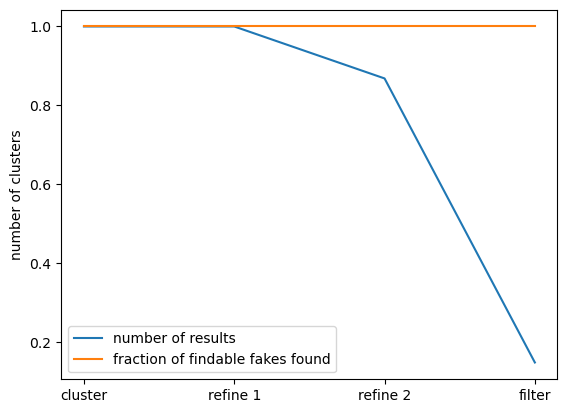

In [176]:
lens = [len(clusters.clusters), len(refined1.clusters), len(refined2.clusters), len(refined_filtered.clusters)]
x = np.arange(len(lens))
plt.plot(x, np.array(lens)/max(lens), label="number of results")
plt.plot(x, fraction_found, label="fraction of findable fakes found")
plt.plot(x, purity, label="purity of fake clusters")
plt.ylabel("number of clusters")
plt.xticks(x, ["cluster", "refine 1", "refine 2", "filter"])
plt.legend()
plt.show()

In [ ]:
# I'm trying to characterize the true positive rate as a function of the refinement/filtering


In [86]:
recover(fakes, clusters, catalog, hough=hough, projection=projection)

{13039521: {'points': {},
  'line': {},
  'catalog': 0,
  'info': {'vra': <Quantity -0.14286354 deg / d>,
   'vdec': <Quantity 0.00333632 deg / d>,
   'min_dv': <Quantity 0.01059939 deg / d>,
   'distance': <Quantity 0.00189071 deg>,
   'findable': True}},
 10564514: {'points': {},
  'line': {},
  'catalog': 0,
  'info': {'vra': <Quantity -0.11873689 deg / d>,
   'vdec': <Quantity 0.12091516 deg / d>,
   'min_dv': <Quantity 0.00778315 deg / d>,
   'distance': <Quantity 0.00027088 deg>,
   'findable': True}},
 14621325: {'points': {6: 85},
  'line': {},
  'catalog': 85,
  'info': {'vra': <Quantity -0.14885475 deg / d>,
   'vdec': <Quantity 0.15269422 deg / d>,
   'min_dv': <Quantity 0.00714488 deg / d>,
   'distance': <Quantity 0.0012745 deg>,
   'findable': True}},
 10053463: {'points': {},
  'line': {},
  'catalog': 0,
  'info': {'vra': <Quantity -0.15100897 deg / d>,
   'vdec': <Quantity 0.00298646 deg / d>,
   'min_dv': <Quantity 0.01263974 deg / d>,
   'distance': <Quantity 0.00225

In [197]:
refined1.clusters[70]

In [201]:
len(refined_filtered.clusters)

51

In [200]:
recover(fakes, refined_filtered)

({13039521: {},
  10564514: {},
  14621325: {6: 85},
  10053463: {},
  13776855: {18: 47, 50: 7},
  14813564: {},
  10041343: {}},
 {13039521: {},
  10564514: {},
  14621325: {6: 104},
  10053463: {},
  13776855: {18: 104, 50: 1},
  14813564: {},
  10041343: {}})

In [189]:
i = 0
cluster = refined1.clusters[i]
line = cluster.extra['line']
t_fake = fakes['mjd_mid'].data[:, None]
line_locations = t_fake @ line.beta * u.day + line.alpha
e = fakes['EXPNUM']
c_line = SkyCoord(
    line_locations[:, 0], 
    line_locations[:, 1]
)
t2 = astropy.table.Table(
    data=[[i]*len(e), c_line.ra, c_line.dec, fakes['EXPNUM'], fakes['ORBITID']], 
    names=['cluster', 'ra', 'dec', 'expnum', 'orbit']
)

c_fake = SkyCoord(
    fakes['RA']*u.deg, 
    fakes['DEC']*u.deg
)
t1 = astropy.table.Table(
    data=[c_fake.ra, c_fake.dec, fakes['ORBITID'], fakes['EXPNUM']], 
    names=['ra', 'dec', 'orbit', 'expnum']
)
for j, g in enumerate(astropy.table.join(t1, t2, keys=['expnum', 'orbit']).group_by(["cluster"]).groups):
    sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
    n_matches = (sep.value < 1/3600).sum()
    print(i, j, n_matches)

0 0 0


In [194]:
astropy.table.join(t1, t2, keys=['expnum', 'orbit']).group_by(["orbit", "cluster"]).groups[0]

ra_1,dec_1,orbit,expnum,cluster,ra_2,dec_2
deg,deg,,,,deg,deg
float64,float64,int64,int32,int64,float64,float64
216.23981819681916,-11.057866904456185,10041343,845872,0,216.22033450785057,-11.02005318013471
216.23931011341227,-11.058032589707828,10041343,845873,0,216.2200630874413,-11.019888328181878
216.2387825978006,-11.058204565388465,10041343,845874,0,216.2197813183684,-11.01971719078665
216.23827445314677,-11.05837018180243,10041343,845875,0,216.21950992611346,-11.019552355933229
216.2377653240385,-11.05853607609234,10041343,845876,0,216.2192380368033,-11.019387219184864
216.23725563669248,-11.058702109512968,10041343,845877,0,216.21896587753872,-11.019221918476433
216.236745910815,-11.05886811316398,10041343,845878,0,216.21869372492802,-11.019056621807977
216.23623388570857,-11.059034823503007,10041343,845879,0,216.21842037146416,-11.018890595780249


In [187]:
t2

cluster,ra,dec,expnum
,deg,deg,
int64,float64,float64,int32
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.02616320217567,-11.023241680213687,845873
6,216.02616320217567,-11.023241680213687,845873


In [180]:
t2

cluster,ra,dec,expnum
,deg,deg,
int64,float64,float64,int32
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.02616320217567,-11.023241680213687,845873
6,216.02616320217567,-11.023241680213687,845873


In [168]:
g = astropy.table.join(t1, t2, keys=['expnum']).group_by(["orbit", "cluster"]).groups[5]
sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
n_matches = (sep.value < 1/3600).sum()
n_matches

645

In [178]:
t2

cluster,ra,dec,expnum
,deg,deg,
int64,float64,float64,int32
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.0264182455703,-11.023502971918788,845872
6,216.02616320217567,-11.023241680213687,845873
6,216.02616320217567,-11.023241680213687,845873


In [177]:
t1[t1['orbit'] == 14621325]

ra,dec,orbit,expnum
deg,deg,,
float64,float64,int64,int32
216.0262513802975,-11.023316132846931,14621325,845872
216.02599674227972,-11.023055741795972,14621325,845873
216.02573236281933,-11.02278540382131,14621325,845874
216.02547768938064,-11.022525003675817,14621325,845875
216.02522252044062,-11.022264108794822,14621325,845876
216.02496706972605,-11.022002936891178,14621325,845877
216.02471159784704,-11.021741753485696,14621325,845878
216.02445497188765,-11.021479399435536,14621325,845879


In [173]:
g

ra_1,dec_1,orbit,expnum,cluster,ra_2,dec_2
deg,deg,,,,deg,deg
float64,float64,int64,int32,int64,float64,float64
216.0262513802975,-11.023316132846931,14621325,845872,6,216.0264182455703,-11.023502971918788
216.0262513802975,-11.023316132846931,14621325,845872,6,216.0264182455703,-11.023502971918788
216.0262513802975,-11.023316132846931,14621325,845872,6,216.0264182455703,-11.023502971918788
216.0262513802975,-11.023316132846931,14621325,845872,6,216.0264182455703,-11.023502971918788
216.0262513802975,-11.023316132846931,14621325,845872,6,216.0264182455703,-11.023502971918788
216.0262513802975,-11.023316132846931,14621325,845872,6,216.0264182455703,-11.023502971918788
216.02599674227972,-11.023055741795972,14621325,845873,6,216.02616320217567,-11.023241680213687
216.02599674227972,-11.023055741795972,14621325,845873,6,216.02616320217567,-11.023241680213687


In [128]:
recover(fakes, clusters, hough=hough, projection=projection)

({13039521: {},
  10564514: {},
  14621325: {6: 85},
  10053463: {},
  13776855: {18: 46, 108: 7},
  14813564: {111: 1},
  10041343: {}},
 {13039521: {},
  10564514: {},
  14621325: {},
  10053463: {},
  13776855: {},
  14813564: {},
  10041343: {}})

In [114]:
%%time

c_fake = SkyCoord(fakes['RA']*u.deg, fakes['DEC']*u.deg)
t1 = astropy.table.Table(data=[c_fake.ra, c_fake.dec, fakes['ORBITID'], fakes['EXPNUM']], names=['ra', 'dec', 'orbit', 'expnum'])

t3 = []
for i, cluster in enumerate(refined1):
    e = cluster.points[:, -1].astype(int)
    c_cluster = SkyCoord(cluster.points[:, 0] * u.deg, cluster.points[:, 1] * u.deg)
    t2 = astropy.table.Table(data=[[i]*len(e), c_cluster.ra, c_cluster.dec, e], names=['cluster', 'ra', 'dec', 'expnum'])
    t3.append(t2)
    
matches = {orbit : {} for orbit in set(fakes['ORBITID'])}
    
t3 = astropy.table.vstack(t3)

for g in astropy.table.join(t1, t3, keys=['expnum']).group_by(["orbit", "cluster"]).groups:
    sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
    n_matches = (sep.value < 1/3600).sum()
    if n_matches > 0:
        matches[g[0]['orbit']][g[0]['cluster']] = n_matches + matches[g[0]['orbit']].get(g[0]['cluster'], 0)
        
matches



CPU times: user 3.54 s, sys: 17 ms, total: 3.56 s
Wall time: 3.54 s


{13039521: {},
 10564514: {},
 14621325: {6: 85},
 10053463: {},
 13776855: {18: 47, 108: 7},
 14813564: {},
 10041343: {70: 3}}

In [115]:
matches

{13039521: {},
 10564514: {},
 14621325: {6: 85},
 10053463: {},
 13776855: {18: 47, 108: 7},
 14813564: {},
 10041343: {70: 3}}

In [113]:
matches

{13039521: {},
 10564514: {},
 14621325: {6: 85},
 10053463: {},
 13776855: {18: 47, 108: 7},
 14813564: {},
 10041343: {70: 3}}

In [76]:
astropy.table.join(t1, t3, keys=['expnum']).group_by(["expnum", "cluster"]).groups[0]

ra_1,dec_1,expnum,cluster,ra_2,dec_2
deg,deg,,,deg,deg
float64,float64,int64,int64,float64,float64
216.27868739584582,-11.039067138719107,845872,0,216.2201427829152,-11.019911675277973


In [75]:

for group in astropy.table.join(t1, t3, keys=['expnum']).group_by(["expnum", "cluster"]).groups:
    sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
    n_matches += (sep < 1 * u.arcsec).sum()
    


KeyboardInterrupt



In [71]:
from salad.analysis.plot import plot_cluster, plot_fake, plot_result
from salad.regression import RegressionResult
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np

cluster = refined1.clusters[0]
match_threshold = 10 * u.arcsec

for fake in fakes.group_by("ORBITID").groups:
    c_fake = SkyCoord(fake['RA']*u.deg, fake['DEC']*u.deg)
    t1 = astropy.table.Table(data=[c_fake.ra, c_fake.dec, fake['EXPNUM']], names=['ra', 'dec', 'expnum'])
    
    for i, cluster in enumerate(refined1):
        e = cluster.points[:, -1].astype(int)
        c_cluster = SkyCoord(cluster.points[:, 0] * u.deg, cluster.points[:, 1] * u.deg)
        t2 = astropy.table.Table(data=[c_cluster.ra, c_cluster.dec, e], names=['ra', 'dec', 'expnum'])
        
        n_matches = 0
        for g in astropy.table.join(t1, t2, keys=['expnum']).group_by("expnum").groups:
            sep = SkyCoord(g['ra_1'], g['dec_1']).separation(SkyCoord(g['ra_2'], g['dec_2']))
            n_matches += (sep < 1 * u.arcsec).sum()
        
        if n_matches > 0:
            print(fake[0]['ORBITID'], i, n_matches)
                
        
#     for row in fake:
#         mask = e == row['EXPNUM']
#         if mask.sum() > 0:
#             f_p = p[mask]
            
# #     astropy.table.join(fake, astropy.table.Table(p), keys_left='EXPNUM', keys_right='')

10041343 70 3



KeyboardInterrupt



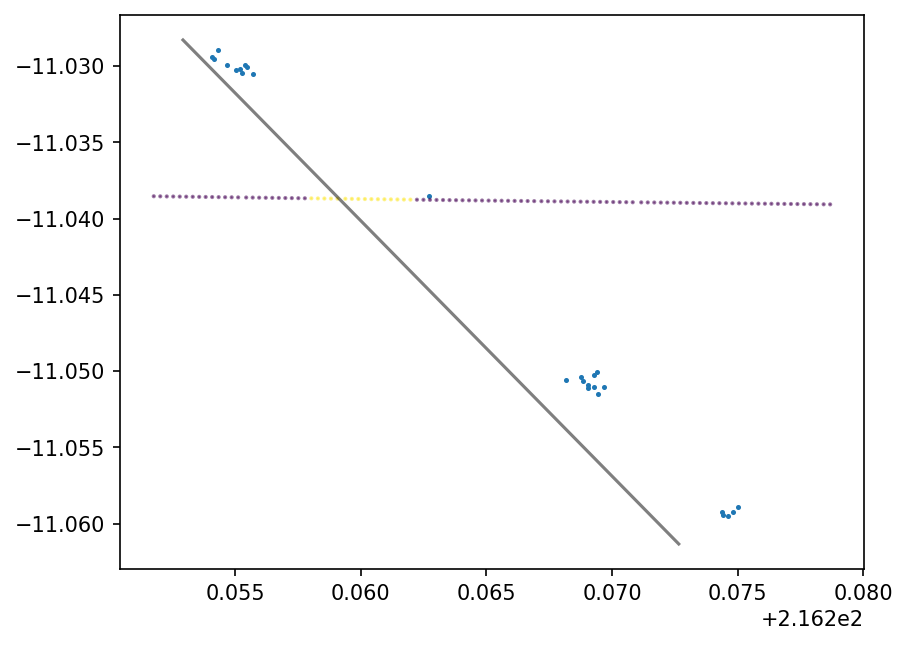

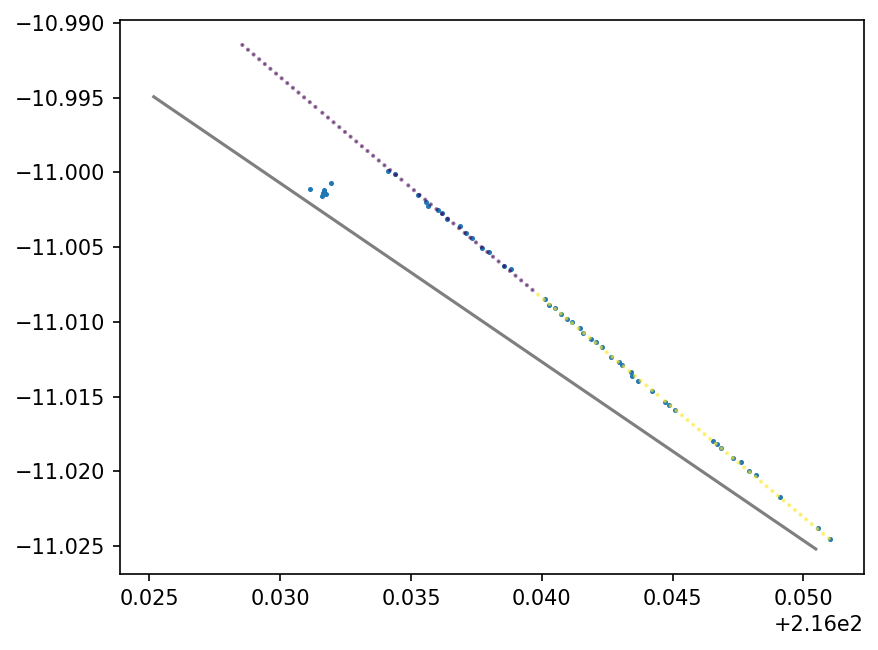

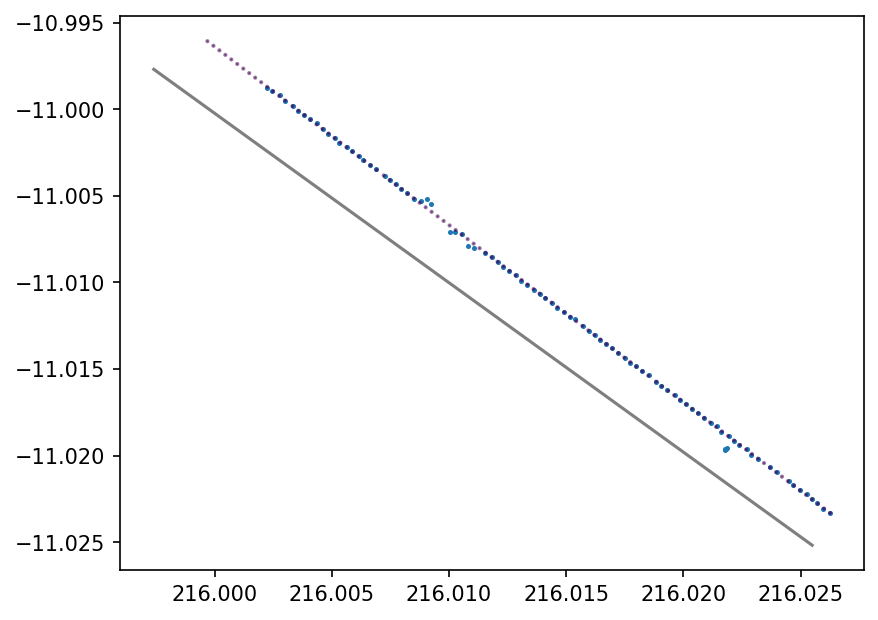

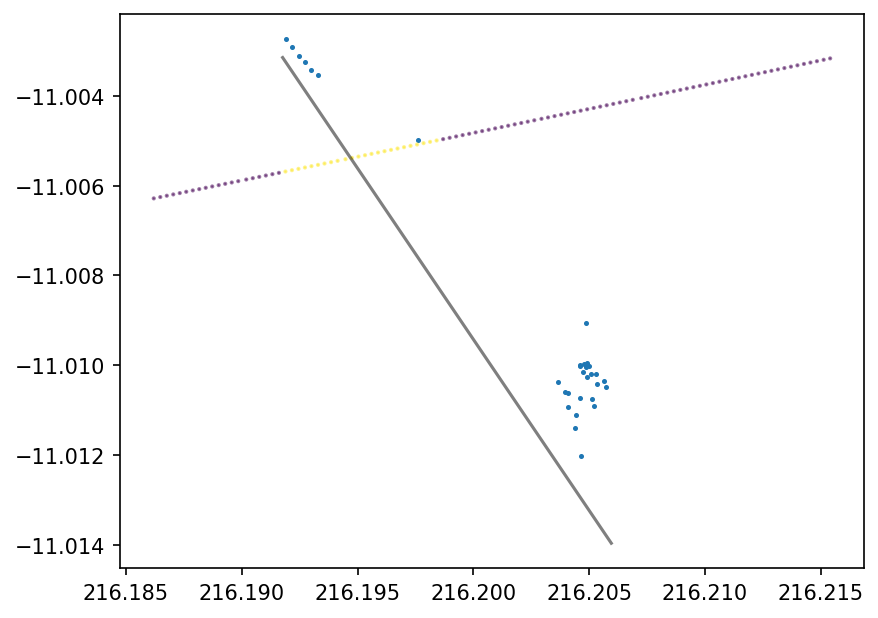

{10041343: {},
 10053463: {106: {'possible': 16, 'points': 26, 'in_cluster': 1}},
 10564514: {},
 13039521: {},
 13776855: {18: {'possible': 52, 'points': 53, 'in_cluster': 47}},
 14621325: {6: {'possible': 104, 'points': 93, 'in_cluster': 93}},
 14813564: {111: {'possible': 24, 'points': 31, 'in_cluster': 1}}}

In [278]:


detections = {}
match_threshold = 10 * u.arcsec

for fake in fakes.group_by("ORBITID").groups:
    orbit = fake[0]['ORBITID']
    detections[orbit] = {}
    
    c_fake = SkyCoord(fake['RA']*u.deg, fake['DEC']*u.deg)
    fakes_lookup = {}

    for i, cluster in enumerate(clusters):
        for x, y, t in cluster.points:
            exposure = match_time_to_exposure(t, catalog)[0]
            if exposure not in fakes_lookup:
                fakes_lookup[exposure] = c_fake[fake['EXPNUM'] == exposure]

    # Q: how many detections made it into the catalog?
    for i, cluster in enumerate(clusters):
        if 'line' in cluster.extra:
            line = cluster.extra['line']
            t_fake = fake['mjd_mid'].data[:, None]
        elif 'b' in cluster.extra:
            alpha = np.array(
                [
                    (cluster.extra['x'] * hough.dx + hough.min_x), 
                    (cluster.extra['y'] * hough.dy + hough.min_y)
                ]
            ) * u.deg
            beta = projection.directions.b[cluster.extra['b']][None, :]
            line = RegressionResult()
            line.beta = beta
            line.alpha = alpha
            t_fake = (fake['mjd_mid'].data[:, None] - projection.reference_time)
        
        line_locations = t_fake @ line.beta * u.day + line.alpha
        
        c_line = SkyCoord(line_locations[:, 0], line_locations[:, 1])
        
        fakes_in_cluster = 0
        cluster_coords = SkyCoord(cluster.points[:, 0] * u.deg, cluster.points[:, 1] * u.deg)
        for j, (coord, t) in enumerate(zip(cluster_coords, cluster.points[:, 2])):
            exposure = match_time_to_exposure(t, catalog)[0]
            fake_coord = fakes_lookup[exposure]
            if len(fake_coord) == 0:
                continue

            if len(fake_coord) > 1:
                print(orbit_id, exposure, len(fake_coord))

            fake_coord = fake_coord[0]
            sep = fake_coord.separation(coord)
            if sep < match_threshold:
                fakes_in_cluster += 1
                
        sep_line = c_fake.separation(c_line)
        
        mask = sep_line < match_threshold
        n_possible = mask.sum()
        n_points = len(cluster.points)
        n_images = len(images.images)
        if fakes_in_cluster/n_points > 0.5:
            detections[orbit][i] = {"possible": n_possible, "points": n_points, "in_cluster": fakes_in_cluster}
            fig = plt.figure(dpi=150)
            plot_result(line, t_fake, color='k', alpha=0.5)
            plot_cluster(cluster, color="C0", s=2)
            plot_fake(orbit, fake, c=mask, s=1, alpha=0.5)
            plt.show()
            
detections

In [25]:
fakes.group_by("ORBITID").groups

<TableGroups indices=[  0 104 208 229 333 437 541 645]>

In [45]:
for fake in fakes.group_by("ORBITID").groups:
    print(fake['mjd_mid'])

     mjd_mid      
------------------
 58577.21447994315
 58577.21619125002
 58577.21796780527
 58577.21967893464
 58577.22139319794
  58577.2231091633
 58577.22482508671
58577.226548581515
58577.228255184666
 58577.22997172023
               ...
58577.375687471955
58577.377399748984
  58577.3791163833
 58577.38083130992
 58577.38254019859
 58577.38427358543
 58577.38598368857
  58577.3877056053
58577.389416230115
 58577.39113802837
 58577.39285936212
Length = 104 rows
     mjd_mid      
------------------
 58577.21447994315
 58577.21619125002
 58577.21796780527
 58577.21967893464
 58577.22139319794
  58577.2231091633
 58577.22482508671
58577.226548581515
58577.228255184666
 58577.22997172023
               ...
58577.375687471955
58577.377399748984
  58577.3791163833
 58577.38083130992
 58577.38254019859
 58577.38427358543
 58577.38598368857
  58577.3877056053
58577.389416230115
 58577.39113802837
 58577.39285936212
Length = 104 rows
     mjd_mid      
------------------
 58577.3580562

In [59]:
(fake['mjd_mid'] - projection.reference_time)[:, None].shape

(104, 1)

In [63]:
(fake['mjd_mid'] - projection.reference_time)[:, None] @ projection.directions.b[179, None]

<Quantity [[ 1.77176704e-04, -1.20796778e-04],
           [-9.21990937e-05,  6.28601456e-05],
           [-3.71845599e-04,  2.53519504e-04],
           [-6.41193456e-04,  4.37157378e-04],
           [-9.11034624e-04,  6.21131584e-04],
           [-1.18114371e-03,  8.05288454e-04],
           [-1.45124620e-03,  9.89440823e-04],
           [-1.72254049e-03,  1.17440575e-03],
           [-1.99117588e-03,  1.35755787e-03],
           [-2.26137472e-03,  1.54177594e-03],
           [-2.53029324e-03,  1.72512109e-03],
           [-2.80042533e-03,  1.90929365e-03],
           [-3.07077648e-03,  2.09361555e-03],
           [-3.34091358e-03,  2.27779152e-03],
           [-3.61048532e-03,  2.46158204e-03],
           [-3.88046002e-03,  2.64564728e-03],
           [-4.15015125e-03,  2.82951926e-03],
           [-4.41974582e-03,  3.01332534e-03],
           [-4.68980936e-03,  3.19745116e-03],
           [-4.96020124e-03,  3.38180084e-03],
           [-5.23058725e-03,  3.56614651e-03],
           [-

In [81]:
from salad.project import project
import numpy as np

In [74]:
t = fake[['RA', 'DEC', 'mjd_mid']]

In [83]:
a = np.array([fake['RA'], fake['DEC'], fake['mjd_mid']]).T
print(a.shape)

(104, 3)


In [85]:
p = project(a, projection.directions, projection.reference_time)

In [86]:
p.projected

array([[[-143.78514106,  -11.00315489],
        [-143.78459207,  -11.00320916],
        [-143.78402218,  -11.0032655 ],
        ...,
        [-143.72903594,  -11.00864067],
        [-143.72848278,  -11.00869408],
        [-143.72792973,  -11.00874748]],

       [[-143.78512353,  -11.00315489],
        [-143.78460119,  -11.00320916],
        [-143.78405896,  -11.0032655 ],
        ...,
        [-143.73174257,  -11.00864067],
        [-143.73121622,  -11.00869408],
        [-143.73068998,  -11.00874748]],

       [[-143.785106  ,  -11.00315489],
        [-143.78461031,  -11.00320916],
        [-143.78409575,  -11.0032655 ],
        ...,
        [-143.7344492 ,  -11.00864067],
        [-143.73394967,  -11.00869408],
        [-143.73345023,  -11.00874748]],

       ...,

       [[-143.78486061,  -11.00271669],
        [-143.78473801,  -11.00343719],
        [-143.78461076,  -11.00418515],
        ...,
        [-143.77234206,  -11.07630648],
        [-143.77221789,  -11.0770302 ],
        [

In [93]:
refined1.clusters[0].extra['line'].beta, refined1.clusters[0].extra['line'].alpha

(<Quantity [[-0.15860417,  0.09633103]] deg / d>,
 <Quantity [ 9506.81089549, -5653.82340943] deg>)

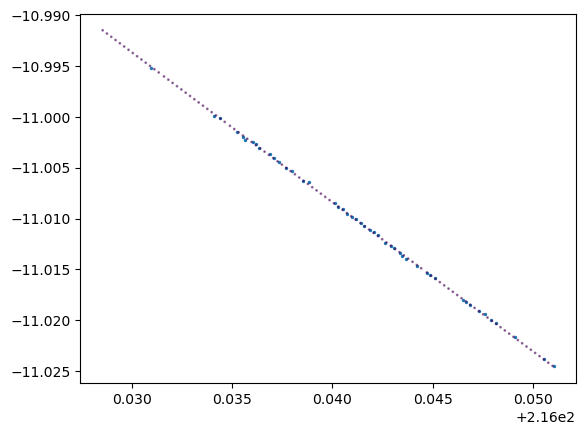

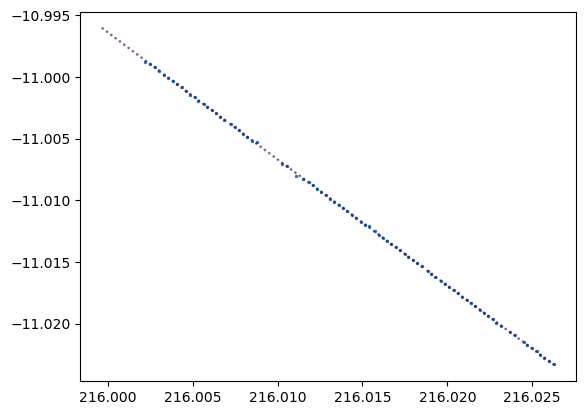

{10041343: [],
 10053463: [],
 10564514: [],
 13039521: [],
 13776855: [(18, 104, 47)],
 14621325: [(6, 104, 85)],
 14813564: []}

In [142]:
from salad.analysis.plot import plot_cluster, plot_fake
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

detections = {}
for fake in fakes.group_by("ORBITID").groups:
    orbit = fake[0]['ORBITID']
    detections[orbit] = []
    # Q: how many detections made it into the catalog?
    for i, cluster in enumerate(refined1):
        line = cluster.extra['line']

        locations = fake['mjd_mid'].data[:, None] @ line.beta * u.day + line.alpha
        c_fake = SkyCoord(fake['RA']*u.deg, fake['DEC']*u.deg)
        c_line = SkyCoord(locations[:, 0], locations[:, 1])

        mask = c_fake.separation(c_line) < 1 * u.arcsec
        n_detected = mask.sum()
        n_points = len(cluster.points)
        n_images = len(images.images)
        if n_detected/n_images > 0.5:
            detections[orbit].append((i, n_detected, n_points))
            plot_cluster(cluster, color="C0", s=2)
            plot_fake(orbit, fake, c=mask, s=1, alpha=0.5)
            plt.show()
            
detections

In [125]:
detections = {}
for fake in fakes.group_by("ORBITID").groups:
    orbit = fake[0]['ORBITID']
    detections[orbit] = []
    for i, cluster in enumerate(refined2):
        line = cluster.extra['line']

        locations = fake['mjd_mid'].data[:, None] @ line.beta * u.day + line.alpha
        c_fake = SkyCoord(fake['RA']*u.deg, fake['DEC']*u.deg)
        c_line = SkyCoord(locations[:, 0], locations[:, 1])

        mask = c_fake.separation(c_line) < 10 * u.arcsec
        n_detected = mask.sum()
        if n_detected > 0:
            detections[orbit].append((i, n_detected))
            
detections

{10041343: [(58, 10)],
 10053463: [(87, 18)],
 10564514: [],
 13039521: [],
 13776855: [(15, 104), (89, 20)],
 14621325: [(6, 104)],
 14813564: []}

In [95]:
fake['mjd_mid'] @ refined1.clusters[0].extra['line'].beta[:, None]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 104)

In [88]:
import astropy.time

times = []
for image in images:
    exposure_info = image.reader.readExposureInfo()
    visit_info = exposure_info.getVisitInfo()
    exposure_date = visit_info.getDate()
    exposure_time = visit_info.getExposureTime()
    half = (exposure_time / 2 + 1/2) / (24*60*60)
    mjd = astropy.time.Time(exposure_date.get(exposure_date.JD) + half, format='jd', scale='utc').mjd
    print(mjd)


58577.34162331978
58577.33991330024
58577.28995492682
58577.33818823891
58577.314166565426
58577.239668010734
58577.345413955394
58577.350590350106
58577.2744987444
58577.376813050825
58577.324465583544
58577.33132773498
58577.29167612828
58577.27620981308
58577.38024196215
58577.25167098874
58577.22767416015
58577.34887263365
58577.36953355977
58577.28823456215
58577.28306610184
58577.385399164166
58577.34333931329
58577.305588313844
58577.35403168155
58577.31930518523
58577.25853315601
58577.35918178875
58577.295296105556
58577.390541809145
58577.31759259151
58577.24652480567
58577.33475460578
58577.36091073789
58577.29700846039
58577.32103756955
58577.37165145762
58577.22595066577
58577.26539428998
58577.21560552204
58577.28477227222
58577.373365429696
58577.37852532789
58577.31245103199
58577.30216465937
58577.24824256776
58577.33304221975
58577.36435971595
58577.27105676662
58577.388831184246
58577.357468087226
58577.34713859856
58577.32789804274
58577.32961164648
58577.2779230526

DateTime("2019-04-04T08:10:55.754802000", TAI)

In [29]:
refined2.clusters[0].extra['line']

<Quantity [[-0.15846679,  0.09632855]] deg / d>

In [48]:
projection.directions.b[179]

<Quantity [-0.15740941,  0.10731969] deg / d>

58577.21560552204

In [9]:
clusters.clusters[0].extra

{'votes': 109, 'b': 179, 'y': 64, 'x': 83}